In [96]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

from utils_notebook import load_enroll, load_test

In [192]:
def analyze(db):
    acc = len(db.query('true_user == pred_cosine')) / len(db)
    
    avg_correct =  db.query('true_user == pred_cosine')['cosine_score'].mean()
    avg_wrong = db.query('true_user != pred_cosine')['cosine_score'].mean()
    
    print(f'Accuracy: {acc}\n')
    print(f'Correct prediction (avg score): {avg_correct}')
    print(f'Wrong prediction (avg score): {avg_wrong}')
    
    idx_wrong = np.where(db['pred_cosine'] != db['true_user'])
    
    return idx_wrong

In [185]:
def plot_cmap(df, n):
    
    # Select n random users
    usres_to_plot = random.sample(list(df.columns), n)
    
    # Select from df
    df_to_plot = df.loc[usres_to_plot][usres_to_plot]
    
    # Plot heat map
    # Note: remove vmin, vmax to normalize between samples
    ax = sns.heatmap(df_to_plot, linewidth=1, cmap='viridis', vmin=-1, vmax=1)
    ax.set_title("Cosine similarity")
    plt.show()
    
    
    # 
    wrong = df_to_plot.mask(np.equal(*np.indices(df_to_plot.shape))).to_numpy().flatten()
    correct = pd.Series(np.diag(df_to_plot))
    
    sns.distplot(wrong, hist=False, norm_hist=False, kde=True, label="Different")
    sns.distplot(correct, hist=False, norm_hist=False, kde=True, label="Same")
    plt.legend()

    axes = plt.gca()
    axes.set_xlim([-1,+1])

In [99]:
def main(path_embd_enroll, path_embd_test):
    enroll_embd = load_enroll(path_embd_enroll)
    users = list(enroll_embd.keys())
    
    test_embd = load_test(path_embd_test)
    
    # Initialize DFs
    
    DB_rows = [] 
    tot = {}
    
    # Iterate

    for to_test, test_user in test_embd:

        max_score = -10**8
        min_score = 10**8
        best_spk = None

        if test_user not in tot.keys():
            tot[test_user]= {'scores': np.zeros(50), 
                             'count': 0}

        scores = []
        for enroll_user in users:
            reference = enroll_embd[enroll_user]

            score = F.cosine_similarity(reference, to_test)
            score = score[0].data.cpu().numpy()

            scores.append(score)

            mse = ((to_test - reference) ** 2).sum().numpy()

            #print(test_user, enroll_user, score)

            if score > max_score:
                best_spk = enroll_user
                max_score = score

            if mse < min_score:
                best_mse = enroll_user
                min_score = mse
                #print('Best user updated!')

        tot[test_user]['scores'] += np.array(scores) 
        tot[test_user]['count'] += 1

        DB_rows.append([test_user, best_spk, max_score, best_mse, min_score])


    # Prepare df
    DB= pd.DataFrame(DB_rows, columns=['true_user', 'pred_cosine', 'cosine_score', 'pred_mse', 'mse_score'])
    
    norm_dict = {k:tot[k]['scores']/tot[k]['count'] for k in tot.keys()}
    df = pd.DataFrame.from_dict(norm_dict, orient='index', columns=users)  # rows reperesnet the true ueser, columns the score of the predicted one
    
    return DB, df

## Trained with contrastive loss

In [100]:
path_embd_test = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embeddings_10/test_samples.csv'
path_embd_enroll =  '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embeddings_10/enroll_samples.csv'
DB, df = main(path_embd_enroll=path_embd_enroll, path_embd_test=path_embd_test)

In [193]:
idx_wrong = analyze(DB)

Accuracy: 0.8128205128205128

Correct prediction (avg score): 0.9104196446175079
Wrong prediction (avg score): 0.8493028614619007


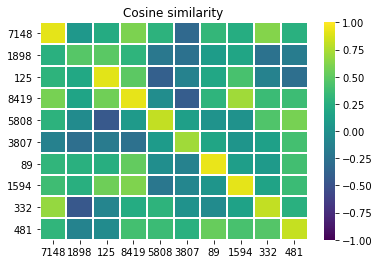

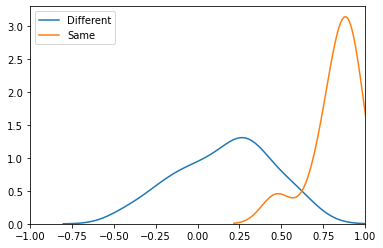

In [197]:
plot_cmap(df, 10)

## Trained with cross-entropy

In [105]:
embd_enroll_old = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/tot_embeddings/enroll_samples.csv'
embd_test_old = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/tot_embeddings/test_samples.csv'
DB_2, df_2 = main(path_embd_enroll=embd_enroll_old, path_embd_test=embd_test_old)

In [194]:
idx_wrong_2 = analyze(DB_2)

Accuracy: 0.8912820512820513

Correct prediction (avg score): 0.9954309320833933
Wrong prediction (avg score): 0.9898698914725825


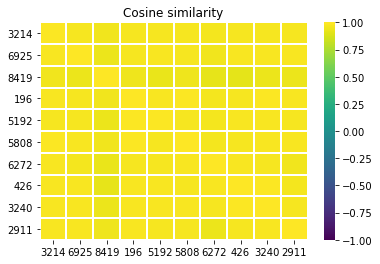

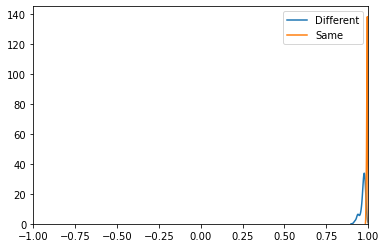

In [196]:
plot_cmap(df_2, 10)